In [3]:
import yfinance as yf
import datetime as dt
import pandas as pd
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import datetime as datetime
import numpy as np
from mpl_finance import candlestick_ohlc

C:\Users\Hp\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\Hp\anaconda3\lib\site-packages\mpl_finance.py:16: DeprecationWarning: 



    Please use `mplfinance` instead (no hyphen, no underscore).

    To install: `pip install --upgrade mplfinance` 

   For more information, see: https://pypi.org/project/mplfinance/


  __warnings.warn('\n\n  ================================================================='+


Enter a stock symbol: AAPL
[*********************100%%**********************]  1 of 1 completed


KeyError: 'SMA_10'

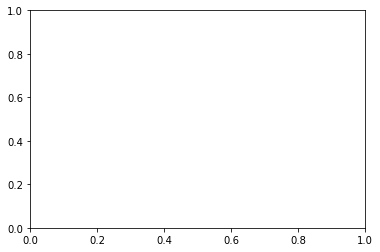

In [6]:
yf.pdr_override()
smaUsed = [10,30,50]

start = dt.datetime(2020,1,1) - dt.timedelta(days = max(smaUsed))
now = dt.datetime.now()
stock = input("Enter a stock symbol: ")

while stock != "quit":
    prices = pdr.get_data_yahoo(stock, start, now)

    fig, ax1 = plt.subplots()

    for x in smaUsed:
        sma = x
        prices["SMA"+str(sma)] = prices.iloc[:,4].rolling(window = sma).mean()

    #Bollinger Bands
    BBperiod = 15
    stdev = 2
    prices['SMA' + str(BBperiod)] = prices.iloc[:,4].rolling(window = BBperiod).mean()
    prices['STDEV'] = prices.iloc[:,4].rolling(window = BBperiod).std()
    prices['LowerBand'] = prices['SMA' + str(BBperiod)]-(stdev*prices['STDEV'])
    prices['LowerBand'] = prices['SMA' + str(BBperiod)]+(stdev*prices['STDEV'])
    prices["Date"] = mdates.date2num(prices.index)

    #10.4.4 Stochastic
    Period = 10
    K = 4
    D = 4
    prices["RolHigh"] = prices["High"].rolling(window = Period).max()
    prices["RolLow"] = prices["Low"].rolling(window = Period).min()
    prices["stok"] = ((prices["Adj Close"]-(prices["RolLow"])/prices["RolHigh"]-prices["RolLow"]))*100
    prices["K"] = prices["stok"].rolling(window = K).mean()
    prices["D"] = prices["K"].rolling(window = D).mean()
    prices["GD"] = prices["High"]

    ohlc = []

    prices = prices.iloc[max(smaUsed):]

    greenDotDate = []
    greenDot = []
    lastK = 0
    lastD = 0
    lastLow = 0
    lastClose = 0
    lastLowBB = 0

    #Go through price history to create candlesticks and GD+Blue dots
    for i in prices.index:
        #append OHLC prices to make the candlestick
        append_me = prices["Date"][i], prices["Low"][i], prices["High"][i], prices["Adj Close"][i], prices["Volume"][i]
        ohlc.append(append_me)
    
        #Check for Green Dot
        if prices["K"][i] > prices["D"][i] and lastK < lastD and lastK < 60:
            plt.plot(prices["Date"][i], prices["High"][i]+1, marker = "o", ms = 4, ls = "", color = 'g')
            greenDotDate.append(i)
            greenDot.append(prices["High"][i])
    
        #Check for lower Bollinger Band Bounce
        if ((lastLow < lastLowBB) or (prices['Low'][i] < prices['LowerBand'][i])) and (prices['Adj Close'][i] > lastClose and prices['Adj Close'][i] > prices['LowerBand'][i] and lastK < 60):
                plt.plot(prices["Date"][i], prices["Low"][i]-1, marker="o", ms=4, ls="", color='b')
        
        #Store Values
        lastK = prices['K'][i]
        lastD = prices['D'][i]
        lastLow = prices['Low'][i]
        lastClose = prices['Adj Close'][i]
        lastLowBB = prices['LowerBand'][i]

        
        #PLot moving averages and BBands
        for x in smaUsed:
            sma = x
            prices['SMA_' + str(sma)].plot(label='close')
            prices['UpperBand'].plot(label='close', color='lightgray')
            prices['LowerBand'].plot(label='close', color='lightgray')

        #Plot Candlesticks

        candlestick_ohlc(ax1, ohlc, width = .5, colorup = 'k', colordown = 'r', alpha = 0.75)

        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax1.xaxis.set_major_locator(mticker.MaxNLocator(8))
        plt.tick_params(axis = 'x', rotation = 45)

        #Pivot Points
        pivots = []
        dates = []
        counter = 0
        lastPivot = 0
        Range = [0,0,0,0,0,0,0,0,0,0]
        dateRange = [0,0,0,0,0,0,0,0,0,0]

        for i in df.index:
            currentMax = max(Range, default = 0)
            value = round(df["High"][i],2)

            Range = Range[1:9]
            Range.append(value)

            dateRange = dateRange[1:9]
            dateRange.append(i)

            if currentMax == max(Range, default = 0):
                counter += 1
            else:
                counter = 0

            if counter == 5:
                lastPivot = currentMax
                dateLoc = Range.index(lastPivot)
                lastDate = dateRange[dateLoc]
                pivots.append(lastPivot)
                dates.append(lastDate)

            print()
            #print(str(pivots))
            #print(str(dates))
            timeD = dt.timedelta(days = 30)

            plt.plot_date([dates[index]-(timeD*.075), dates[index]+timeD],
                          [pivots[index], pivots[index]], linestyle = '--', linewidth = 1, marker = "")
            plt.annotate(str(pivots[index]), (mdates.date2num(dates[index]), pivots[index]), xytext = (-10, 7),
                         textcoords = 'offset points', fontsize = 7, arrowprops = dict(arrowstyle = '-|>'))

        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.title(stock+" - Daily")
        plt.ylim(prices["Low"].min(), prices["High"].max()*1.05)

        plt.show()

        stock = input("Enter a stock symbol: ")